# Production of Animal Products in Mainland China
# 中国大陆动物产品的生产情况

## Ready to work  准备

### Import Libraries 导入工具库

In [1]:
# import necessary libs

import os
import time
import datetime
import json
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms

from bs4 import BeautifulSoup

import folium
from folium import plugins
from matplotlib_venn import venn2, venn3, venn3_circles

%matplotlib inline

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

In [3]:
path_img = './results/CN_AnimalProduction/img/'
path_map = './results/CN_AnimalProduction/img/'
for path in [path_img, path_map]:
    for i in os.listdir(path):
        path_file = os.path.join(path,i)  
        if os.path.isfile(path_file):
              os.remove(path_file)

In [4]:
# what is the relevent path of root
root_where = '../../'
print('+++++++++ Atention ++++++++++')
print(f'The root is set as "{root_where}" relevent to this file.' )
print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
print('+++++++++++++++++++++++++++++')
print('')

LOCAL_ROOT = os.path.abspath(root_where)

DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
DATA_FAO = os.path.join(DATA_BASE, 'FAO')
DATA_NBS = os.path.join(DATA_BASE, 'NBS')
DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')

NBS_meta = os.path.join(DATA_NBS, 'metadata')

FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'

print(f'Root director: {LOCAL_ROOT}')
print(f'Data director: {DATA_BASE}')
print(f'FAO data director: {DATA_FAO}')
print(f'NBS data director: {DATA_NBS}')
print(f'Datasets hybrids director: {DATA_hybrids}')
print('')
print(f'NBS metadata director: {NBS_meta}')
print('')
print(f'FAO metadata director: {FAO_meta}')
print(f'FAO local description file: {FAO_description_path}')
print(f'FAO local datasets zip: {FAO_BULK_zip}')
print('')

SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
print(f'Suffix of raw FAO data file name: {SUFFIX}')

+++++++++ Atention ++++++++++
The root is set as "../../" relevent to this file.
If it is not right, you change this parameter where the parameter name is "root_where".
+++++++++++++++++++++++++++++

Root director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas
Data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data
FAO data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/FAO
NBS data director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/NBS
Datasets hybrids director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/hybrids

NBS metadata director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/NBS/metadata

FAO metadata director: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/FAO/metadata
FAO local description file: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/FAO/metadata/datasets_E.xml
FAO local datasets zip: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/data/FAO/FAOSTAT.zip

Suffix of raw FAO data file name: _E_All_Data_(Normalized)


### Read Data Frame 读取数据

- 'MeatProduction_clean.csv' is the data needed in this program. See how the data was obtained and cleaned: [CN_AnimalProduction_DataCleaning](CN_AnimalProduction_DataCleaning);

- 'AnimalProduction_clean_doc.csv' explains the data's feilds;

- 'GeoNameSheet_cn.csv' lists all the mainland China's areas;

In [5]:
data = pd.read_csv(DATA_hybrids+'/AnimalProduction_clean.csv')
doc = pd.read_csv(DATA_hybrids+'/AnimalProduction_doc.csv')
geoname = pd.read_csv(NBS_meta+'/GeoNameSheet_cn.csv')
display(doc)
display(data.head())
display(geoname.head())
# display(data.head())
# display(geoname.head())

Item-En 项目名称: Item_Cn  \
0                            Area            地区   
1                            Year            年份   
2                   Stock, cattle         存栏量_牛   
3             Stock, goat & sheep     存栏量_山羊&绵羊   
4                      Stock, pig         存栏量_猪   
5                    Stock, birds        存栏量_禽类   
6             Slaughtered, cattle         屠宰量_牛   
7       Slaughtered, goat & sheep     屠宰量_山羊&绵羊   
8                Slaughtered, pig         屠宰量_猪   
9              Slaughtered, birds        屠宰量_禽类   
10        Meat Production, cattle         肉产量_牛   
11  Meat Production, goat & sheep     肉产量_山羊&绵羊   
12           Meat Production, pig         肉产量_猪   
13         Meat Production, birds        肉产量_禽类   
14          Egg Production, birds           蛋产量   
15           Milk Production, cow         奶产量_牛   
16             Meat Yield, cattle        单位产量_牛   
17       Meat Yield, goat & sheep    单位产量_山羊&绵羊   
18                Meat Yield, pig        单位产量_猪   
19              Meat Yield, birds       单位产量_禽类   
20                 Aquatic, total          水产总量   
21               Aquatic, animals         水产肉类量   
22                  Marine, total          海水产量   
23                Marine, capture       海水产量_捕捞   
24            Marine, aquaculture       海水产量_养殖   
25                    Marine Fish        海水产量_鱼   
26             Marine Crustaceans       海水产量_虾蟹   
27                Marine Molluscs       海水产量_贝类   
28                  Marine Plants       海水产量_藻类   
29                 Marine, others       海水产量_其他   
30              Freshwater, total          淡水产量   
31            Freshwater, capture       淡水产量_捕捞   
32        Freshwater, aquaculture       淡水产量_养殖   
33                Freshwater Fish        淡水产量_鱼   
34         Freshwater Crustaceans       淡水产量_虾蟹   
35            Freshwater Molluscs       淡水产量_贝类   
36             Freshwater, others       淡水产量_其他   

                                                                        Explanation-En  \
0   Name of countries, areas or China's provinces (or provincial level areas of China)   
1                                                                               Years.   
2                                                         Numbers of stocks of cattle.   
3                                   Numbers of stocks of the total of goats and sheep.   
4                                                           Numbers of stocks of pigs.   
5                                                          Numbers of stocks of birds.   
6                                              Numbers of slaughtered cattle for meat.   
7                                     Numbers of slaughtered goats and sheep for meat.   
8                                                Numbers of slaughtered pigs for meat.   
9                 Numbers of slaughtered birds for meat, mainly from chicken and duck.   
10                                                 Weights of meat produced by cattle.   
11                                         Weights of meat produced by goat and sheep.   
12                                                    Weights of meat produced by pig.   
13                    Weights of meat produced by birds, ainly from chicken and duck.    
14                    Weights of eggs produced by birds, mainly from chicken and duck.   
15                                              Weights of fresh milk produced by cow.   
16                                     Mean value of weights of meat from each cattle.   
17                              Mean value of weights of meat from each goat or sheep.   
18                                        Mean value of weights of meat from each pig.   
19         Mean value of weights of meat from each bird. Mainly from chicken and duck.   
20                                               Total weights of aquatic productions.   
21                                                            Weights of aquatic meat.   
22               

Area  Year  Stock, cattle  Stock, goat & sheep  Stock, pig  \
0  China, mainland  1961         4940.0              11281.0      8227.0   
1  China, mainland  1962         4676.0              12387.0      7552.0   
2  China, mainland  1963         4736.0              13465.0      9997.0   
3  China, mainland  1964         4894.0              13747.0     13180.0   
4  China, mainland  1965         5242.0              13669.0     15247.0   

   Stock, birds  Slaughtered, cattle  Slaughtered, goat & sheep  \
0       62600.0                 50.6                     1000.0   
1       64200.0                 69.0                     1000.0   
2       66300.0                 92.5                     1200.0   
3       68400.0                103.5                     1400.0   
4       69000.0                116.0                     1570.0   

   Slaughtered, pig  Slaughtered, birds  Meat Production, cattle  \
0            3300.0             54500.0                      4.3   
1            4300.0             56400.0                      6.2   
2            7800.0             58000.0                      8.3   
3           10500.0             59400.0                      9.3   
4           12167.0             61600.0                     10.4   

   Meat Production, goat & sheep  Meat Production, pig  \
0                           10.0                 137.0   
1                           10.0                 178.0   
2                           12.0                 330.0   
3                           14.0                 450.0   
4                           16.0                 525.0   

   Meat Production, birds  Egg Production, birds  Milk Production, cow  \
0                   57.00                  150.0                  60.0   
1                   59.00                  152.0                  62.0   
2                   60.75                  154.0                  63.5   
3                   62.25                  158.0                  64.0   
4                   64.50                  162.0                  64.5   

   Meat Yield, cattle  Meat Yield, goat & sheep  Meat Yield, pig  \
0                85.0                 10.000000             41.5   
1                89.9                 10.000000             41.4   
2                89.7                 10.000000             42.3   
3                89.9                 10.000000             42.9   
4                89.7                 10.191083             43.1   

   Meat Yield, birds  Aquatic Production, total  Aquatic Production, animals  \
0           1.045872                        NaN                          NaN   
1           1.046099                        NaN                          NaN   
2           1.047414                        NaN                          NaN   
3           1.047980                        NaN                          NaN   
4           1.047078                        NaN                          NaN   

   Marine, total  Marine, capture  Marine, aquac.  Marine Fish  \
0            NaN              NaN             NaN          NaN   
1            NaN              NaN             NaN          NaN   
2            NaN              NaN             NaN          NaN   
3            NaN              NaN             NaN          NaN   
4            NaN              NaN             NaN          NaN   

   Marine Crustaceans  Marine Molluscs  Marine Plants  Marine, others  \
0                 NaN              NaN            NaN             NaN   
1                 NaN              NaN            NaN             NaN   
2                 NaN              NaN            NaN             NaN   
3                 NaN              NaN            NaN             NaN   
4                 NaN              NaN            NaN             NaN   

   Freshwater, total  Freshwater, capture  Freshwater, aquac.  \
0                NaN                  NaN                 NaN   
1                NaN                  NaN                 NaN   
2                NaN          

Area Code             Area       Region
0         41  China, mainland    East Asia
1       1001          Beijing  North China
2       1002          Tianjin  North China
3       1003            Hebei  North China
4       1004           Shanxi  North China

In [6]:
df = pd.merge(geoname, data, on='Area', how='outer')

print('The shape and the head of the data frame:')
print(df.shape)
display(df.head())

The shape and the head of the data frame:
(677, 39)


Area Code             Area     Region  Year  Stock, cattle  \
0         41  China, mainland  East Asia  1961         4940.0   
1         41  China, mainland  East Asia  1962         4676.0   
2         41  China, mainland  East Asia  1963         4736.0   
3         41  China, mainland  East Asia  1964         4894.0   
4         41  China, mainland  East Asia  1965         5242.0   

   Stock, goat & sheep  Stock, pig  Stock, birds  Slaughtered, cattle  \
0              11281.0      8227.0       62600.0                 50.6   
1              12387.0      7552.0       64200.0                 69.0   
2              13465.0      9997.0       66300.0                 92.5   
3              13747.0     13180.0       68400.0                103.5   
4              13669.0     15247.0       69000.0                116.0   

   Slaughtered, goat & sheep  Slaughtered, pig  Slaughtered, birds  \
0                     1000.0            3300.0             54500.0   
1                     1000.0            4300.0             56400.0   
2                     1200.0            7800.0             58000.0   
3                     1400.0           10500.0             59400.0   
4                     1570.0           12167.0             61600.0   

   Meat Production, cattle  Meat Production, goat & sheep  \
0                      4.3                           10.0   
1                      6.2                           10.0   
2                      8.3                           12.0   
3                      9.3                           14.0   
4                     10.4                           16.0   

   Meat Production, pig  Meat Production, birds  Egg Production, birds  \
0                 137.0                   57.00                  150.0   
1                 178.0                   59.00                  152.0   
2                 330.0                   60.75                  154.0   
3                 450.0                   62.25                  158.0   
4                 525.0                   64.50                  162.0   

   Milk Production, cow  Meat Yield, cattle  Meat Yield, goat & sheep  \
0                  60.0                85.0                 10.000000   
1                  62.0                89.9                 10.000000   
2                  63.5                89.7                 10.000000   
3                  64.0                89.9                 10.000000   
4                  64.5                89.7                 10.191083   

   Meat Yield, pig  Meat Yield, birds  Aquatic Production, total  \
0             41.5           1.045872                        NaN   
1             41.4           1.046099                        NaN   
2             42.3           1.047414                        NaN   
3             42.9           1.047980                        NaN   
4             43.1           1.047078                        NaN   

   Aquatic Production, animals  Marine, total  Marine, capture  \
0                          NaN            NaN              NaN   
1                          NaN            NaN              NaN   
2                          NaN            NaN              NaN   
3                          NaN            NaN              NaN   
4                          NaN            NaN              NaN   

   Marine, aquac.  Marine Fish  Marine Crustaceans  Marine Molluscs  \
0             NaN          NaN                 NaN              NaN   
1             NaN          NaN                 NaN              NaN   
2             NaN          NaN                 NaN              NaN   
3             NaN          NaN                 NaN              NaN   
4             NaN          NaN                 NaN              NaN   

   Marine Plants  Marine, others  Freshwater, total  Freshwater, capture  \
0            NaN             NaN                NaN                  NaN   
1            NaN             NaN                NaN                  NaN   
2            NaN             NaN        

Show the latest year of data and store the value to 'DATA_YEAR'

In [9]:
"""
the domain of the table called 'Animal Production'
the items include:
    'Meat Production, pig', 'Meat Production, cattle', 'Meat Production, goat & sheep',
    'Meat Production, birds', 'Aquatic Production, animals', 
    'Egg Production, birds', 'Milk Production, cow'
the latest year of data will be stored in variable 'DATA_YEAR'
"""

D = 'Animal Production'             # Domain, will appear as names of Y_labels, legends, titles and so on.
Is = [
    'Meat Production, pig', 'Meat Production, cattle', 'Meat Production, goat & sheep',
    'Meat Production, birds', 'Aquatic Production, animals', 
    'Egg Production, birds','Milk Production, cow'
]                                   # Items, data in these columns will be visualized

DATA = df[['Area Code', 'Area', 'Year']+Is]
DATA = DATA.dropna().drop_duplicates()

Years = DATA['Year'].unique()               
print ('The datasets years cover: ', Years)

The datasets years cover:  [1978 1980 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017]


### Plot style settings 设置输出风格

In [10]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (6, 3)
DPI = 300

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# 猪，牛，羊，禽肉，鱼，蛋，奶
CLs = ('#ffab91','#c62828','#689f38','#ff6f00','#80deea','#ffc400','#1e88e5',)
MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

# =============================================================================================================
def setX_quant(ax, ticks, step, label = ''):
    ax.set_xticks(ticks)
    ax.set_xlim(ticks[0]-step/2,ticks[-1]+step/2)
    ax.set_xticklabels(ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
#     ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setX_quali(ax, ticks, label = ''):
    ax.set_xticklabels(ticks, rotation=90, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
#     ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

def setY_quant(ax, y_max, label = ''):
    tick_num = 9
    step = y_max/(tick_num-1)
    min_gap = 10
    
    if step < 1:
        step = round(step,1)
        dec=1
    elif step < 10:
        step = int(step)
        dec=0
    elif step/min_gap < 10:
        step = int(step/min_gap)*10
        dec=0
    else:
        n=0
        while step/min_gap >= 10:
            step = int(step/min_gap)
            n += 1
        step = int(step/min_gap)*(min_gap**(n+1))
        dec=0
        
    y_max = step*(tick_num+1)        
    ticks = np.round(np.arange(0, y_max+step, step),decimals=dec)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1]+step)
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel(label, fontsize=LAB_size) 
#     ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setY_per(ax):
    ticks=np.round(np.linspace(0, 100, num=11, endpoint=True), decimals=0)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1])
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel('Percentage (%)', fontsize=LAB_size)
#     ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

## Results 结果

### Production Trends of Animal Products in Mainland China 
### 中国大陆动物产品产量趋势

- Create line plot to show Production Trends of Animal Products;
- As well as stacked bar plots (in absolute values and in percentages).

In [11]:
def plotTrends(
    domain_,    # string, name of the domain, will be plot in title
    df_,        # dataframe, the gross dataframe
    area_,      # string, the area need to be visualized
    items_,     # list, column names of items, the values will be plot as Y value, the name will be plot as legends
    fig_size,  
):
    """
    Create pivots for each Y column from a dataframe of a particular area, then:
    - Line plot of data from 1980 to DATA_YEAR
    - Stacked bar (absolute values), steped by 5 years
    - Stacked bar (percentages), steped by 5 years
    Save img
    """
    

    
    fig = plt.figure(figsize = fig_size, dpi = 300)
    fig.tight_layout()                          
    plt.subplots_adjust(wspace =0.5, hspace =0.15) 

    step = 5                                                         # for X ticks
    X_ticks = range(1980, 2015+step, step)  # X ticks
    Y_lab = domain_+' (10,000 t)'                                    # Y label
    title = "Production Trends of Animal Products in {}".format(area_)              # title
    
    # Create sub dataframes only contains a particular area
    df_ = df_.copy()
    df_area = df_[df_['Area']==area_]
    
    # Create a dict where the key is item and the value is dataframe of an item of a particular area
    dfs = {}
    for n in range(len(items_)):
        dfs[items_[n]] = df_area[['Year',items_[n]]].dropna()

    # === 1. Line plot ===
    ax0 = fig.add_subplot(3,1,1)
    plt.title(title+"\n", fontsize=TIT_size)            # add title only above the first subplot
    
    y_maxes = np.array([])
    for n in range(len(items_)):
        dfs[items_[n]].plot.line(x='Year', c=CLs[n], lw=LIN_wei, ax=ax0)
        y_maxes = np.append(y_maxes,dfs[items_[n]][items_[n]].max())

    ax=plt.gca()
    ax.legend(labels=items_, loc='center left', frameon=False, fontsize=LEG_size,
           bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
    
    setX_quant(ax, X_ticks, step)
    setY_quant(ax, y_maxes.max(), Y_lab)
    
    # === 2. Stacked bar (absolute values) ===
    ax1 = fig.add_subplot(3,1,2)

    bot=np.zeros(len(X_ticks))
    for n in range(len(items_)):
        y = np.array(dfs[items_[n]][dfs[items_[n]]['Year'].isin(X_ticks)][items_[n]])    
        plt.bar(X_ticks, y ,bottom=bot,color=CLs[n], width=BAR_wid)
        bot=bot + y
    totals = bot

    #     matplotlib.pyplot.text(x, y, s, fontdict=None, withdash=False, **kwargs)
    
    ax=plt.gca()
    ax.legend(labels=items_, loc='center left', frameon=False, fontsize=LEG_size,
           bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
    setX_quant(ax, X_ticks, step)
    setY_quant(ax, totals.max(), Y_lab)
    
    # === 3. Stacked bar (percentages) ===
    ax2 = fig.add_subplot(3,1,3)

    bot=np.zeros(len(X_ticks))
    for n in range(len(items_)):
        y = np.array(dfs[items_[n]][dfs[items_[n]]['Year'].isin(X_ticks)][items_[n]])/totals*100
        plt.bar(X_ticks, y ,bottom=bot,color=CLs[n], width=BAR_wid)
        bot = bot+y
        
#     matplotlib.pyplot.text(x, y, s, fontdict=None, withdash=False, **kwargs)

    ax=plt.gca()
    ax.legend(labels=items_, loc='center left', frameon=False, fontsize=LEG_size,
           bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
    
    setX_quant(ax, X_ticks, step)
    setY_per(ax)
    
#     # Save img
#     path = './results/CN_AnimalProduction/img/Fig_1_'+title+'.png'
#     bbox = matplotlib.transforms.Bbox([[-1, 0], [10, 15]])
#     fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#     print('Img saved as: ' + path)

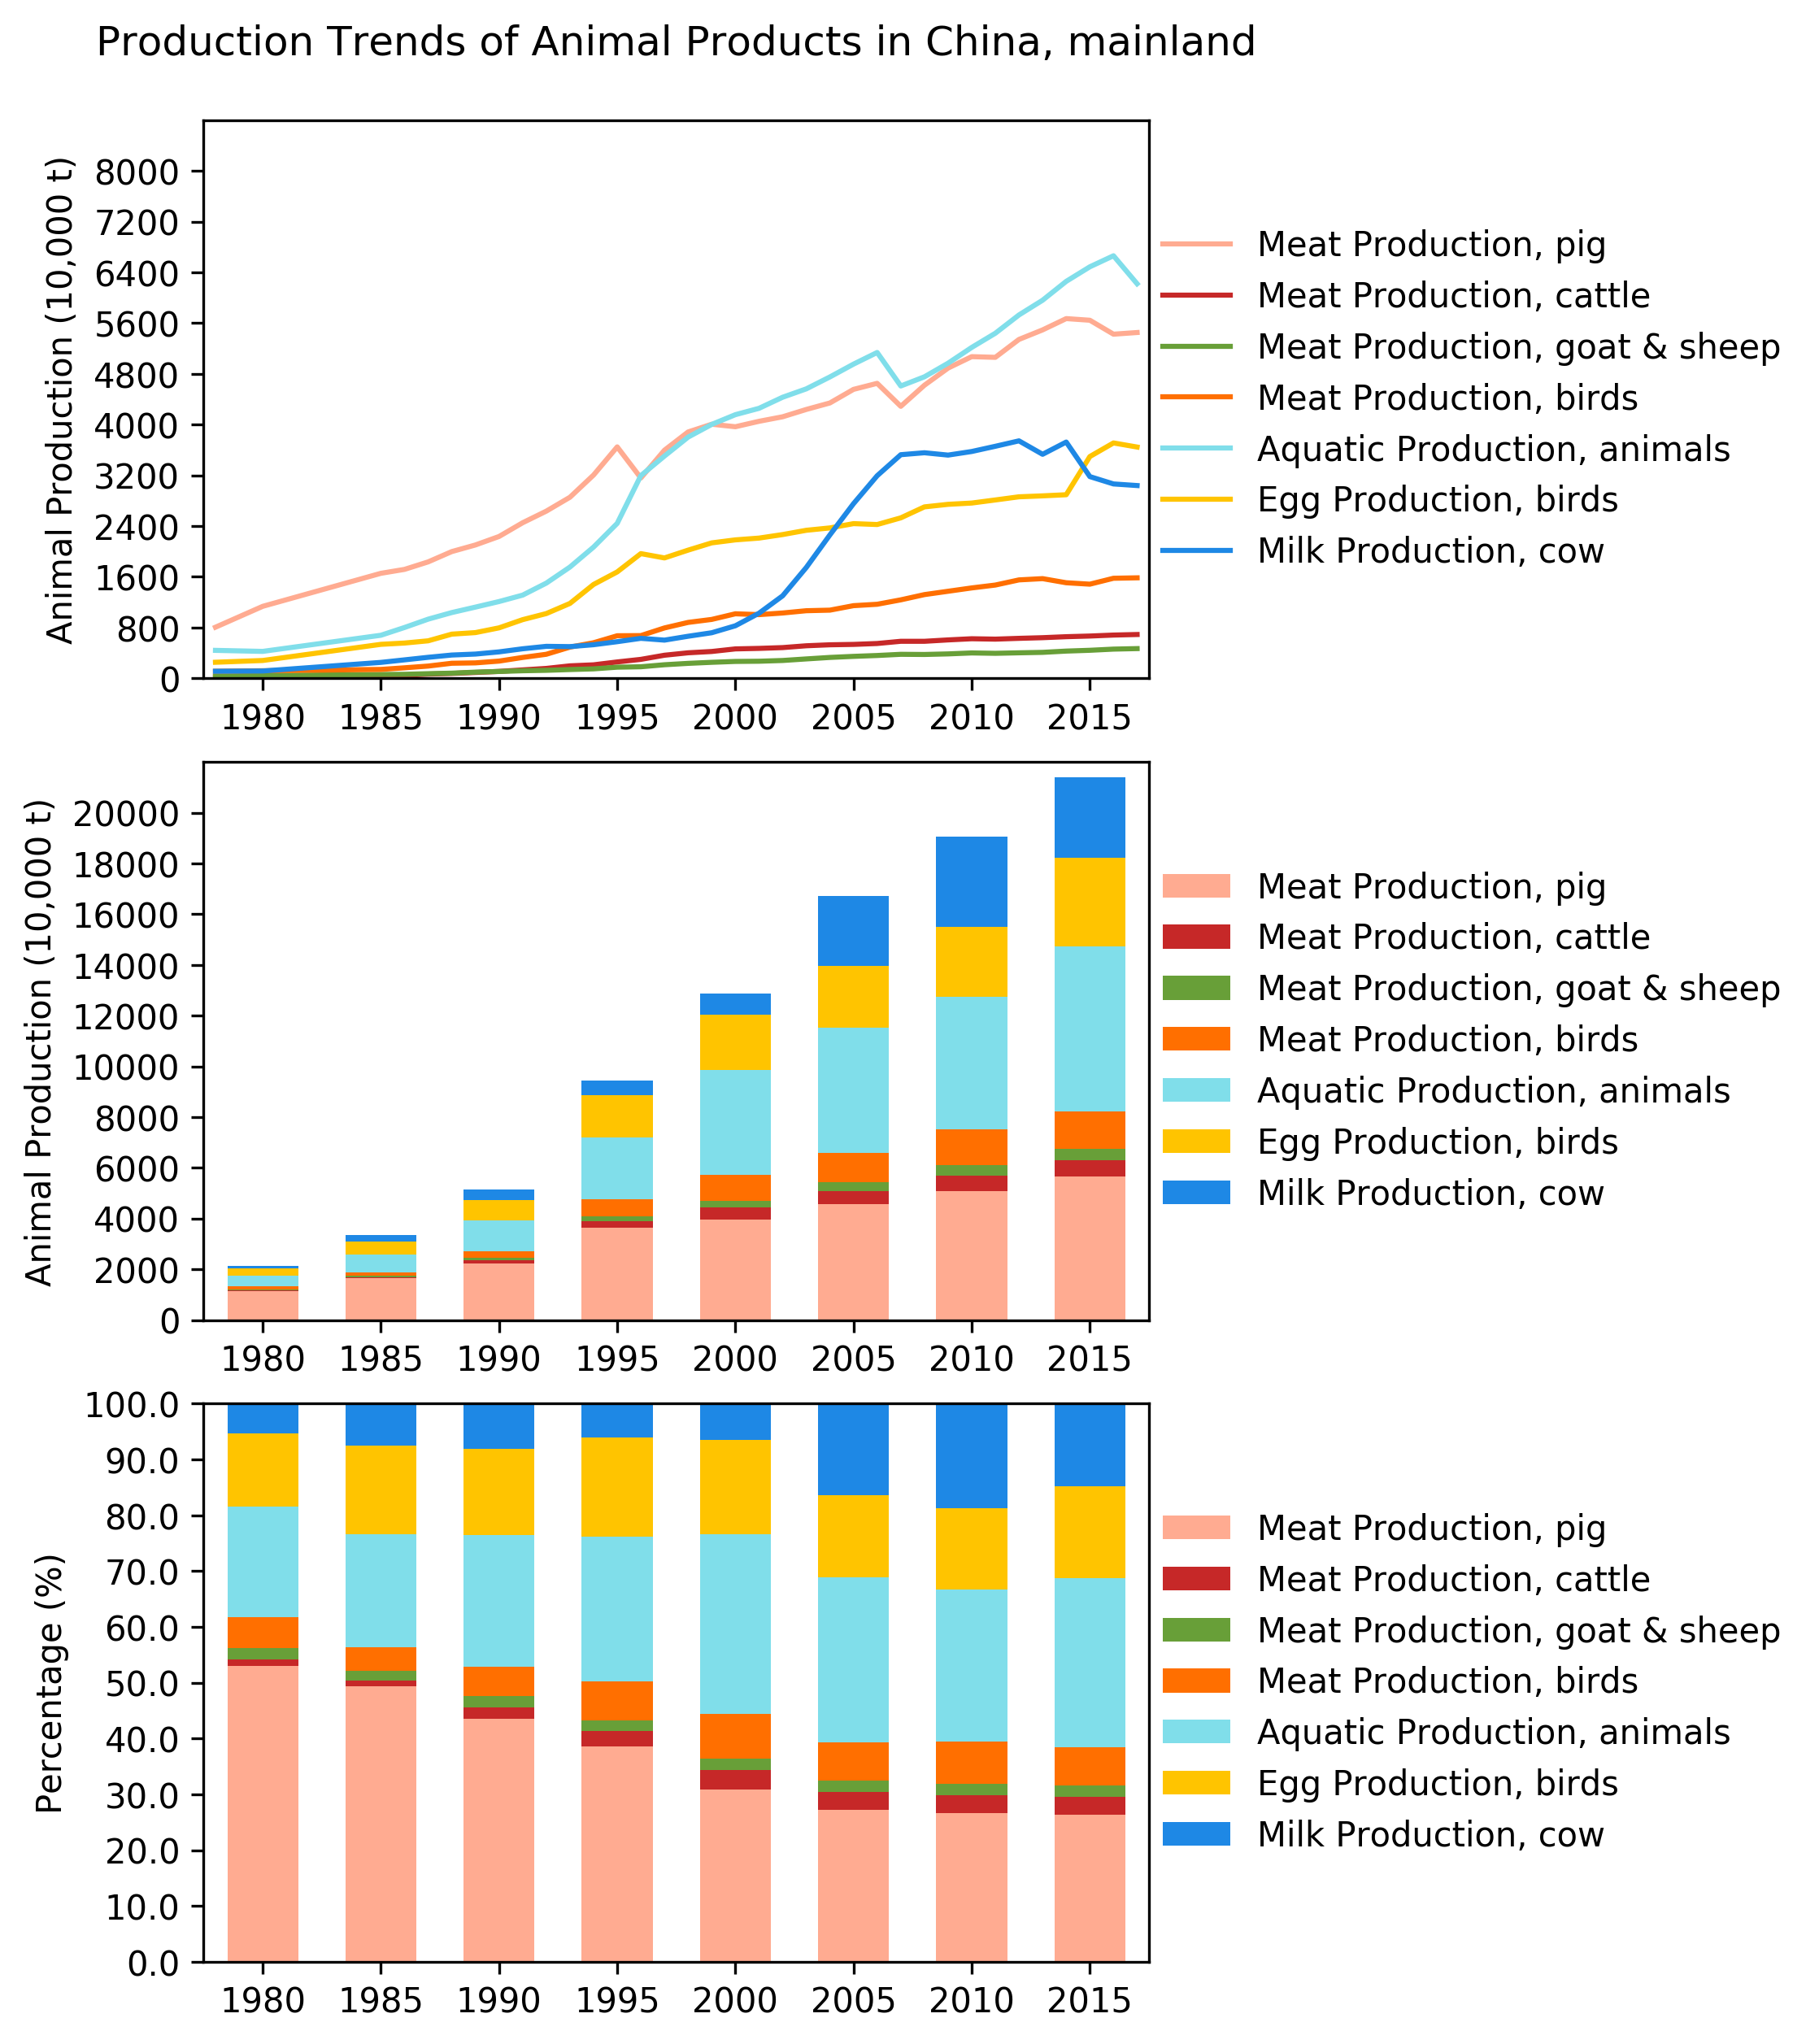

In [12]:
area = 'China, mainland'  # also can be other area name in the 'Area' column
 
plotTrends( 
    domain_=D,                
    df_=DATA,
    items_=Is,
    area_=area,                                           
    fig_size = (5, 10)
)

### The Production Rankings of Animal Products Sorted by Areas in Mainland China 
### 中国大陆各种动物产品产量按省份排名

- Ranked by the historical total during year 2000 to latest year;
- Show the value during the year 2000 to latest year steped by 5 years.

In [13]:
def toPivot(
    df_,         # dataframe, the gross dataframe
    item_,       # string, the item that should be plot
    sortedVal_,  # int/string, the columns that should be sorted by
):
    """
    extract the data of the particular item from gross dataframe to make a pivot
    where years as columns and areas as indicies
    sort the indecies by values of one column or by 'Historical Total'
    """

    years = range(2000, Years[-1])                    
    
    # create a sub dataframe with certain areas during certain years
    df_ = df_.copy()
    df_ = df_[(~df_['Area'].isin(['China, mainland'])) & (df_['Year'].isin(years))]
    # pivot it with a particular item where area as index year as column
    df_ = pd.pivot_table(df_,index=['Area'],columns=['Year'],values=[item_],aggfunc=[np.sum],margins=1)
    
    # flat multi-index
    df_.columns.set_names([None, None, None], inplace=True)    # reset multi index name
    df_.columns = df_.columns.get_level_values(-1)
    
    # fix the columns order and name
    fixed_columns = [df_.columns[-1]] + list(df_.columns[:-1])
    df_ = df_[fixed_columns]
    df_.rename(columns = {'All':'Historical Total'}, inplace=True)
    df_ = df_.drop(index = 'All')
    
    # sort areas by the 'Historical Total'
    sorted_df = df_.sort_values([sortedVal_], ascending=False, axis=0)
    sorted_df = sorted_df.reset_index()
    return sorted_df

In [16]:
def plotRankedBar(
    domain_,
    df_,         # dataframe, the gross dataframe
    items_,      # list, the items that should be transfered to pivots by toPivot() and be displayed in the plots
    sortedVal_,  # int/string, the indices should be sorted by values of one column or by 'Historical Total'
    fig_size,
):
    """
    Transfer the gross dataframe to sorted pivots by toPivot()
    Display each pivot as dataframe
    Plot each pivot to a bar plot:
        the X ticks should be the indices sorted by the values of a particular column wich should be a particular year or 'Historical Total'
        the Y axis should be the value of 'Animal Production' in areas in steped years
    Save img
    """
    
    df_ = df_.copy()
    
    # set the colors for the bar
    colors = ['#00acc1']
    
    fig = plt.figure(figsize = (3,60), dpi = 300)
    fig.tight_layout()                          
    plt.subplots_adjust(hspace =0.1)
    
    years = [2016]                            # years for displaying bars
    Y_lab = domain_+' (10,000 t)'                                           # Y label 

    n=0
    for i in items_:
        pivot = toPivot(df_, i, sortedVal_)

        n+=1
        fig.add_subplot(len(items_),1,n)

        title = "{} in {}".format(i.title(), sortedVal_)  # titles        
        plt.title(title, fontsize=TIT_size)
        
        print(i)
#         display(pivot[['Area']+years].head())                               # display pivots
        pivot[['Area']+years].plot.barh(x='Area', width=0.6, color=colors, ax=plt.gca())

#         ax=plt.gca()
#         Y_max=pivot[years].values.max()
#         setY_quant(ax, 1.2*Y_max, Y_lab)
#         X_ticks=pivot['Area'].values
#         setX_quali(ax, X_ticks)
        plt.xticks([])
    
        ax = plt.gca()
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:^.0f}'.format(width), (x+width*1.01, y+0.5), fontsize=LEG_size)
            
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_legend().remove()

        ax = plt.gca().invert_yaxis()


    path = f'{LOCAL_ROOT}/results/CN_AnimalProduction/img/Fig_2_'+'Ranked Meat Productions Bar 2016'+'.png'
    bbox = matplotlib.transforms.Bbox([[-1, -1], [5, 70]])
    fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
    print('Img saved as: ' + path)

Meat Production, pig
Meat Production, cattle
Meat Production, goat & sheep
Meat Production, birds
Aquatic Production, animals
Egg Production, birds
Milk Production, cow
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_AnimalProduction/img/Fig_2_Ranked Meat Productions Bar 2016.png


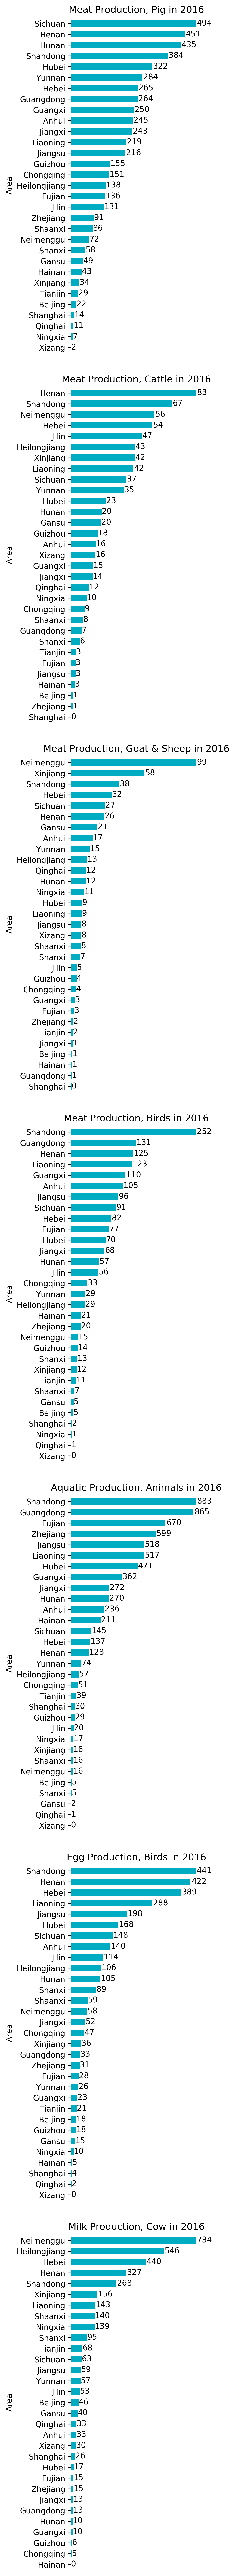

In [17]:
"""
Visualize the Animal Production in Different Area and Sorted by Historical total:
the domain and items is the same as above
the sorted Value: the Areas in X axis should be sorted by 'Historical Total'
"""
sortedVal = 2016     # also can be an int between 2000 and DATA_YEAR

plotRankedBar(
    domain_=D,
    df_=DATA, 
    items_=Is,
    sortedVal_=sortedVal,
    fig_size=(9,36)
)

### Animal Production Atlas in Mainland China
### 中国大陆动物产品产量地图

- Display the data of particular animal product in particular year by color maps;
- The values linspace are divided into six levels linearly, each color represent a level, the darker the greater.

In [45]:
def plotAtlas(
    df_,           # dataframe, the gross dataframe
    items_,         # string, selected item
    year_,         # int, selected year
    geo_data_,     # geojson file
    fill_color_,   # string, select a fill_color strategy in folium
    tag_,          # string, for recognization when giving title and saving files
):

    df_ = df_.copy()
    
    # create a dict of sub dataframes that made of 
    # a particular year, a particular item, ertain areas
    # and sorted by item value
    dfs = {}
    df_sorted = pd.DataFrame([])
    for i in items_:
        dfs[i] = df_[df_['Year']==year_][['Area',i]]
        dfs[i] = dfs[i].sort_values([i],ascending=False).reset_index(drop=True)
        df_sorted = pd.concat([df_sorted, dfs[i]], axis=1, join='outer', ignore_index=False)
    display(df_sorted)
   
    for i in items_:
        title = "{} {} {}".format(str(year_), i, tag_)
        cn_map = folium.Map( width=1000, height=600, location=[40, 105], zoom_start=4, tiles='Mapbox Bright') 
        
        dfs[i] = dfs[i][~dfs[i]['Area'].isin(['China, mainland'])]
        threshold_scale = np.linspace(
            dfs[i][i].values.min(), 
            dfs[i][i].values.max(), 
            6, dtype=int)
        threshold_scale = threshold_scale.tolist()      # change the numpy array to a list
        threshold_scale[-1] = threshold_scale[-1] + 1   # make sure that the last value of the list is greater than the maximum immigration
        
        folium.Choropleth(
            geo_data=geo_data_,
            data=dfs[i],
            name = i,
            columns=['Area', i],
            key_on='feature.properties.NAME',
            threshold_scale=threshold_scale,
            nan_fill_color='gray',
            fill_color=fill_color_,
            fill_opacity=1, 
            line_opacity=0.2,
            legend_name=title,
            show=False,
            highlight=False,
            reset=False
        ).add_to(cn_map)
        
        path = f'{LOCAL_ROOT}/results/CN_AnimalProduction/map/{title}.html'
        cn_map.save(path)
#         display(cn_map)
        print('Atalas saved as: ' + path)

__注意：下个cell输出结果为地图，不能直接在文本中显示地图，请根据结果输出的地址自行查看__

In [46]:
"""
Plot Atlas:
the items is same as above
the years: an integer between 1999 and the latest year
a blank map named 'cn_provinces.geojson' should be already in the current dir
"""

year = Years[-1]-1    # also can be an int between 2000 and DATA_YEAR, but when use DATA_year, some atla my not work because lack of data 

plotAtlas(
    df_=DF, 
    items_=Is, 
    year_=year, 
    geo_data_ = f'{LOCAL_ROOT}geojson/cn_provinces.geojson',
    fill_color_='GnBu',
    tag_='(10,000 t)'
)

NameError: name 'DATA_YEAR' is not defined

In [ ]:
path = 'your/path/map.html'
soup = BeautifulSoup(open(path), "html.parser")
head = soup.head
head.append(soup.new_tag('style', type='text/css'))
head.style.append(' .leaflet-popup-content-wrapper {background-color:black; color:white}')
with open(path, "w") as file: file.write(str(soup))

### Venn Diagram of Top Areas
### 总产量领先地区的韦恩图

In [20]:
def drawVenn2(set1,set2,set1_name,set2_name):
    fig_size = (6, 3)
    fig = plt.figure(figsize=fig_size, dpi=300)
    v0 = venn2([set1, set2], (set1_name, set2_name))

    try:
        v0.get_patch_by_id('10').set_color('red')
    except:pass
    try:
        v0.get_patch_by_id('01').set_color('blue')
    except:pass
    try:
        v0.get_patch_by_id('11').set_color('purple')
    except:pass

    try:
        v0.get_label_by_id('10').set_text('\n\n '.join(set1.difference(set2)))
    except:pass
    try:
        v0.get_label_by_id('01').set_text('\n\n '.join(set2.difference(set1)))
    except:pass
    try:
        v0.get_label_by_id('11').set_text('\n\n '.join(set1.intersection(set2)))
    except:pass

    for text in v0.subset_labels:
        try:
            text.set_fontsize(7)
        except:
            continue

    for text in v0.set_labels:
        try:
            text.set_fontsize(7)
        except:
            continue
    
    path = './results/CN_AnimalProduction/img/'+'venn_'+set1_name+'_'+set2_name+'.png'
    fig.savefig(path)
    print('Img saved as: ' + path)
    
def drawVenn3(set1, set2, set3, set1_name, set2_name, set3_name):
    fig_size = (6, 3)
    fig = plt.figure(figsize=fig_size, dpi=300)
    v1 = venn3([set1, set2, set3], (set1_name, set2_name, set3_name))

    try:
        v1.get_patch_by_id('100').set_color('red')
    except:pass
    try:
        v1.get_patch_by_id('010').set_color('yellow')
    except:pass
    try:
        v1.get_patch_by_id('001').set_color('blue')
    except:pass
    try:    
        v1.get_patch_by_id('110').set_color('orange')
    except:pass
    try:    
        v1.get_patch_by_id('101').set_color('purple')
    except:pass
    try:    
        v1.get_patch_by_id('011').set_color('green')
    except:pass
    try:    
        v1.get_patch_by_id('111').set_color('grey')
    except:pass

    try:    
        v1.get_label_by_id('100').set_text('\n\n\n\n\n'+'\n\n '.join(set1.difference(set2.union(set3))))
    except:pass  
    try:
        v1.get_label_by_id('010').set_text('\n\n '.join(set2.difference(set1.union(set3)))+'\n\n\n\n\n')
    except:pass
    try:
        v1.get_label_by_id('001').set_text('\n\n '.join(set3.difference(set2.union(set1))))
    except:pass
    try:
        v1.get_label_by_id('110').set_text('\n\n '.join((set1.intersection(set2)).difference(set3)))
    except:pass
    try:
        v1.get_label_by_id('101').set_text('\n\n '.join((set1.intersection(set3)).difference(set2)))
    except:pass
    try:
        v1.get_label_by_id('011').set_text('\n\n '.join((set3.intersection(set2)).difference(set1)))
    except:pass
    try:
        v1.get_label_by_id('111').set_text('\n\n '.join(((set1.intersection(set2)).intersection(set3))))
    except:pass

    for text in v1.subset_labels:
        try:
            text.set_fontsize(7)
        except:continue

    for text in v1.set_labels:
        try:
            text.set_fontsize(7)
        except:continue
    
    path = './results/CN_AnimalProduction/img/'+'venn_'+set1_name+'_'+set2_name+'_'+set3_name+'.png'
    fig.savefig(path)
    print('Img saved as: ' + path)

__地图颜色将等级区分为五级，按等级自上而下，选取合适的数量，具体方法如下:__
   ```
   if (first > 3): top = first
   elif (first + second > 3): top = first + second
   elif (first + second + third > 6): top = first + second
   else: top = first + second + third
   ```
   注： top 指被选为 top 的地方； first 是图例上颜色最深的省份的数量，sencond 和 third 依次类推

In [21]:
# top_pig={'Sichuan', 'Henan', 'Hunan', 'Shandong', 'Hubei'}
# top_cattle={'Henan', 'Shandong', 'Neimenggu', 'Hebei'}
# top_shp_gt={'Neimenggu', 'Xinjiang'}

# top_poultry={'Shandong', 'Guangdong', 'Henan', 'Liaoning', 'Guangxi', 'Anhui'}
# top_aquatic={'Shandong', 'Guangdong', 'Fujian', 'Zhejiang'}

# top_egg={'Shandong', 'Henan', 'Hebei', 'Liaoning'}
# top_milk={'Neimenggu', 'Heilongjiang', 'Hebei', 'Henan'}

Img saved as: ./results/CN_AnimalProduction/img/venn_Pork Meat_Bovine Meat_Mutton & Goat Meat.png


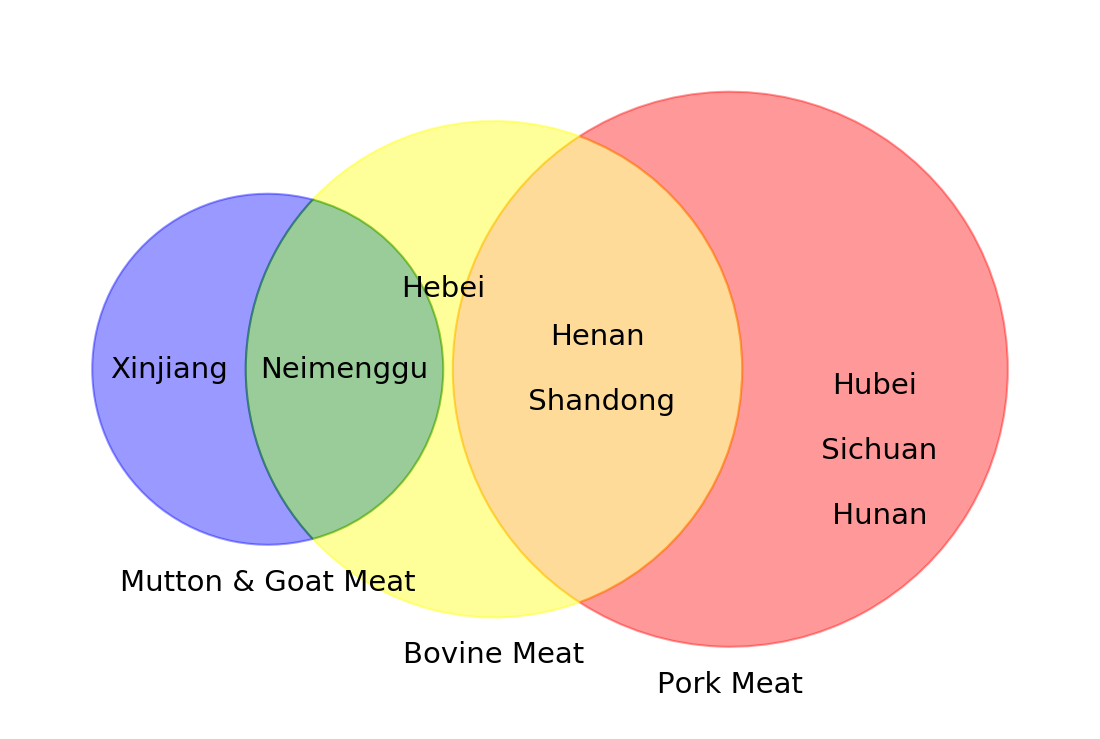

In [22]:
# set1=top_pig
# set2=top_cattle
# set3=top_shp_gt
# set1_name='Pork Meat'
# set2_name='Bovine Meat'
# set3_name='Mutton & Goat Meat'

# drawVenn3(set1, set2, set3, set1_name, set2_name, set3_name)

Img saved as: ./results/CN_AnimalProduction/img/venn_Poultry Meat_Aquatic Meat.png


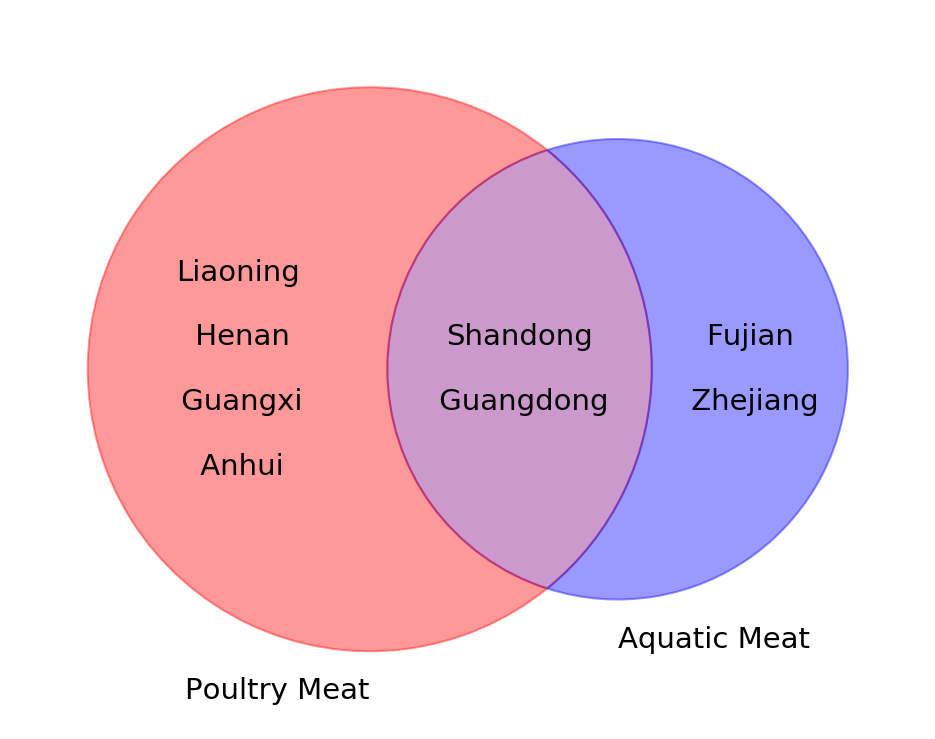

In [23]:
set1=top_poultry
set2=top_aquatic
set1_name='Poultry Meat'
set2_name='Aquatic Meat'

drawVenn2(set1,set2,set1_name,set2_name)

Img saved as: ./results/CN_AnimalProduction/img/venn_Egg_Milk.png


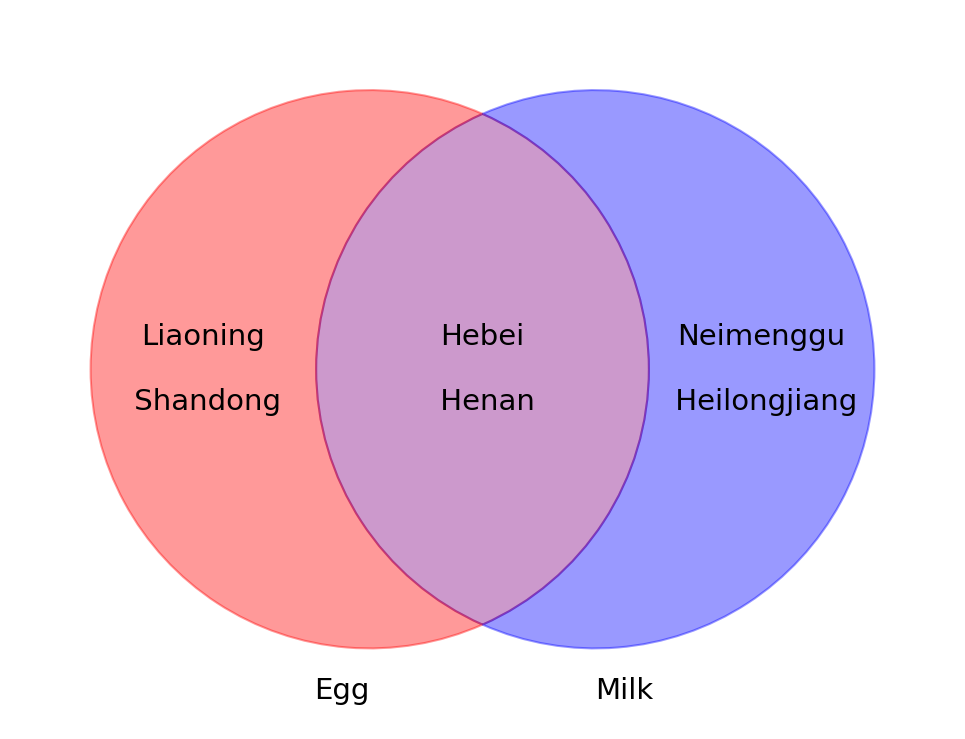

In [24]:
set1=top_egg
set2=top_milk
set1_name='Egg'
set2_name='Milk'

drawVenn2(set1,set2,set1_name,set2_name)

Img saved as: ./results/CN_AnimalProduction/img/venn_Red Meat_White Meat_Egg & Milk.png


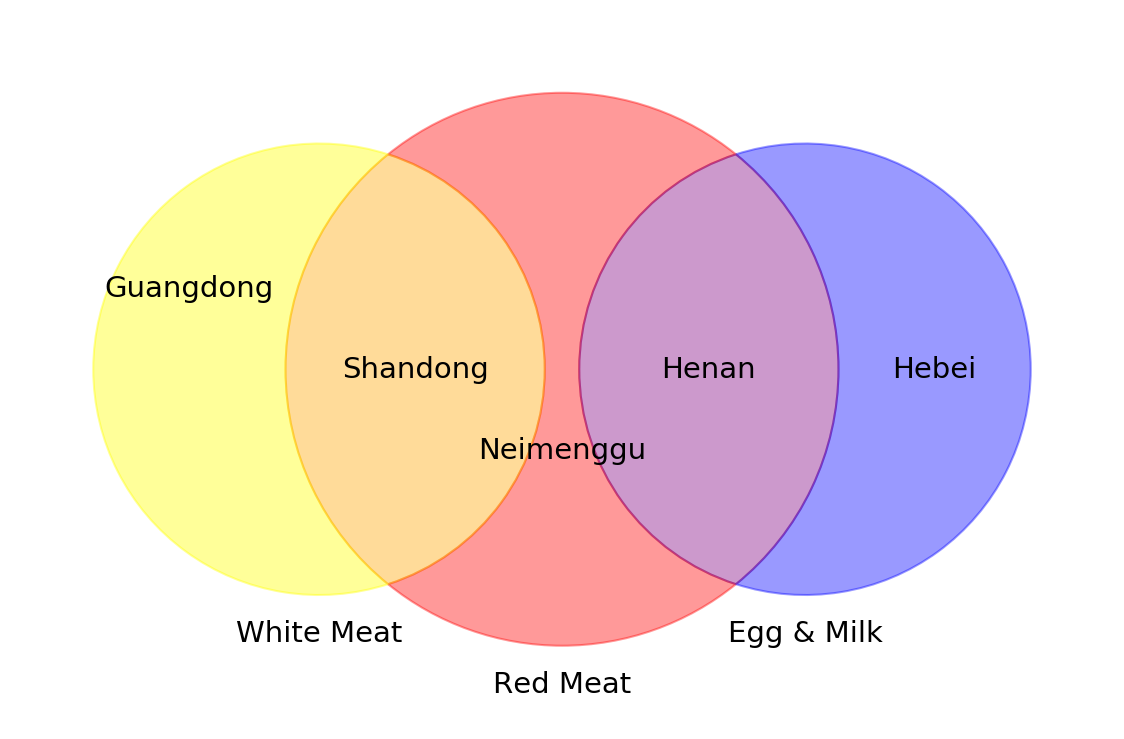

In [25]:
top_red={'Shandong','Henan','Neimenggu'}
top_white={'Guangdong', 'Shandong'}
top_egg_milk={'Hebei', 'Henan'}

set1=top_red
set2=top_white
set3=top_egg_milk
set1_name='Red Meat'
set2_name='White Meat'
set3_name='Egg & Milk'
drawVenn3(set1,set2,set3,set1_name,set2_name,set3_name)

### Productivity Evaluation
### 生产效率评估

In [26]:
def plotProductivity(
    df_, 
    area_, 
    fig_size,
):
    
    items = ['pig', 'cattle', 'goat & sheep', 'birds']
    df_=df_.copy()
    
    for i in items:

        # items name
        item11 = 'Stock, '+i
        item12 = 'Slaughtered, '+i
        item2 = 'Meat Production, '+i
        item3 = 'Meat Yield, '+i
        
        # df made of selected items
        df_res = df_[df_['Area']==area_][['Year',item11,item12,item2,item3]]
        
        # canvas and axes
        fig, ax = plt.subplots(figsize=fig_size, dpi = 300)
        title = 'Productivity of {} Production'.format(i.title())
        plt.title(title, fontsize=TIT_size)
        ax2, ax3=ax.twinx(),ax.twinx()
        rspine = ax3.spines['right']
        rspine.set_position(('axes', 1.2))
        ax3.set_frame_on(True)
        ax3.patch.set_visible(False)
        fig.subplots_adjust(right=0.75)

        # === Stock & Slaughtered
        df_res[['Year',item11,item12]].plot(x='Year', ax=ax)
        ax.legend(loc = 'upper left')
        Y_max=df_res[[item11,item12]].values.max()
        setY_quant(ax, 1.5*Y_max, 'Stock or Slaughtered (10,000 heads)')

        # === Meat Production
        df_res[['Year',item2]].plot(x='Year', c='green', ls=':', ax=ax2)
        ax2.legend(loc = 'upper right')
        Y_max=df_res[[item2]].values.max()
        setY_quant(ax2,1.1*Y_max , 'Meat Production (10,000 t)')

        # === Meat Yield
        df_res[['Year',item3]].plot(x='Year', c='orange', ls='-.', ax=ax3)
        ax3.legend(loc = 'lower right')
        Y_max=df_res[[item3]].values.max()
        setY_quant(ax3, 1.1*Y_max, 'Meat Yield (kg/head)')
        
        # draw X ticks
        step=10
        X_ticks= list(range(1965,2025,step))
        setX_quant(ax, X_ticks ,step)

        # === Save img
        path = './results/CN_AnimalProduction/img/Fig_3_'+title+'.png'
        bbox = matplotlib.transforms.Bbox([[-2, -0], [10, 5]])
        fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
        print('Img saved as: ' + path)

Img saved as: ./results/CN_AnimalProduction/img/Fig_3_Productivity of Pig Production.png
Img saved as: ./results/CN_AnimalProduction/img/Fig_3_Productivity of Cattle Production.png
Img saved as: ./results/CN_AnimalProduction/img/Fig_3_Productivity of Goat & Sheep Production.png
Img saved as: ./results/CN_AnimalProduction/img/Fig_3_Productivity of Birds Production.png


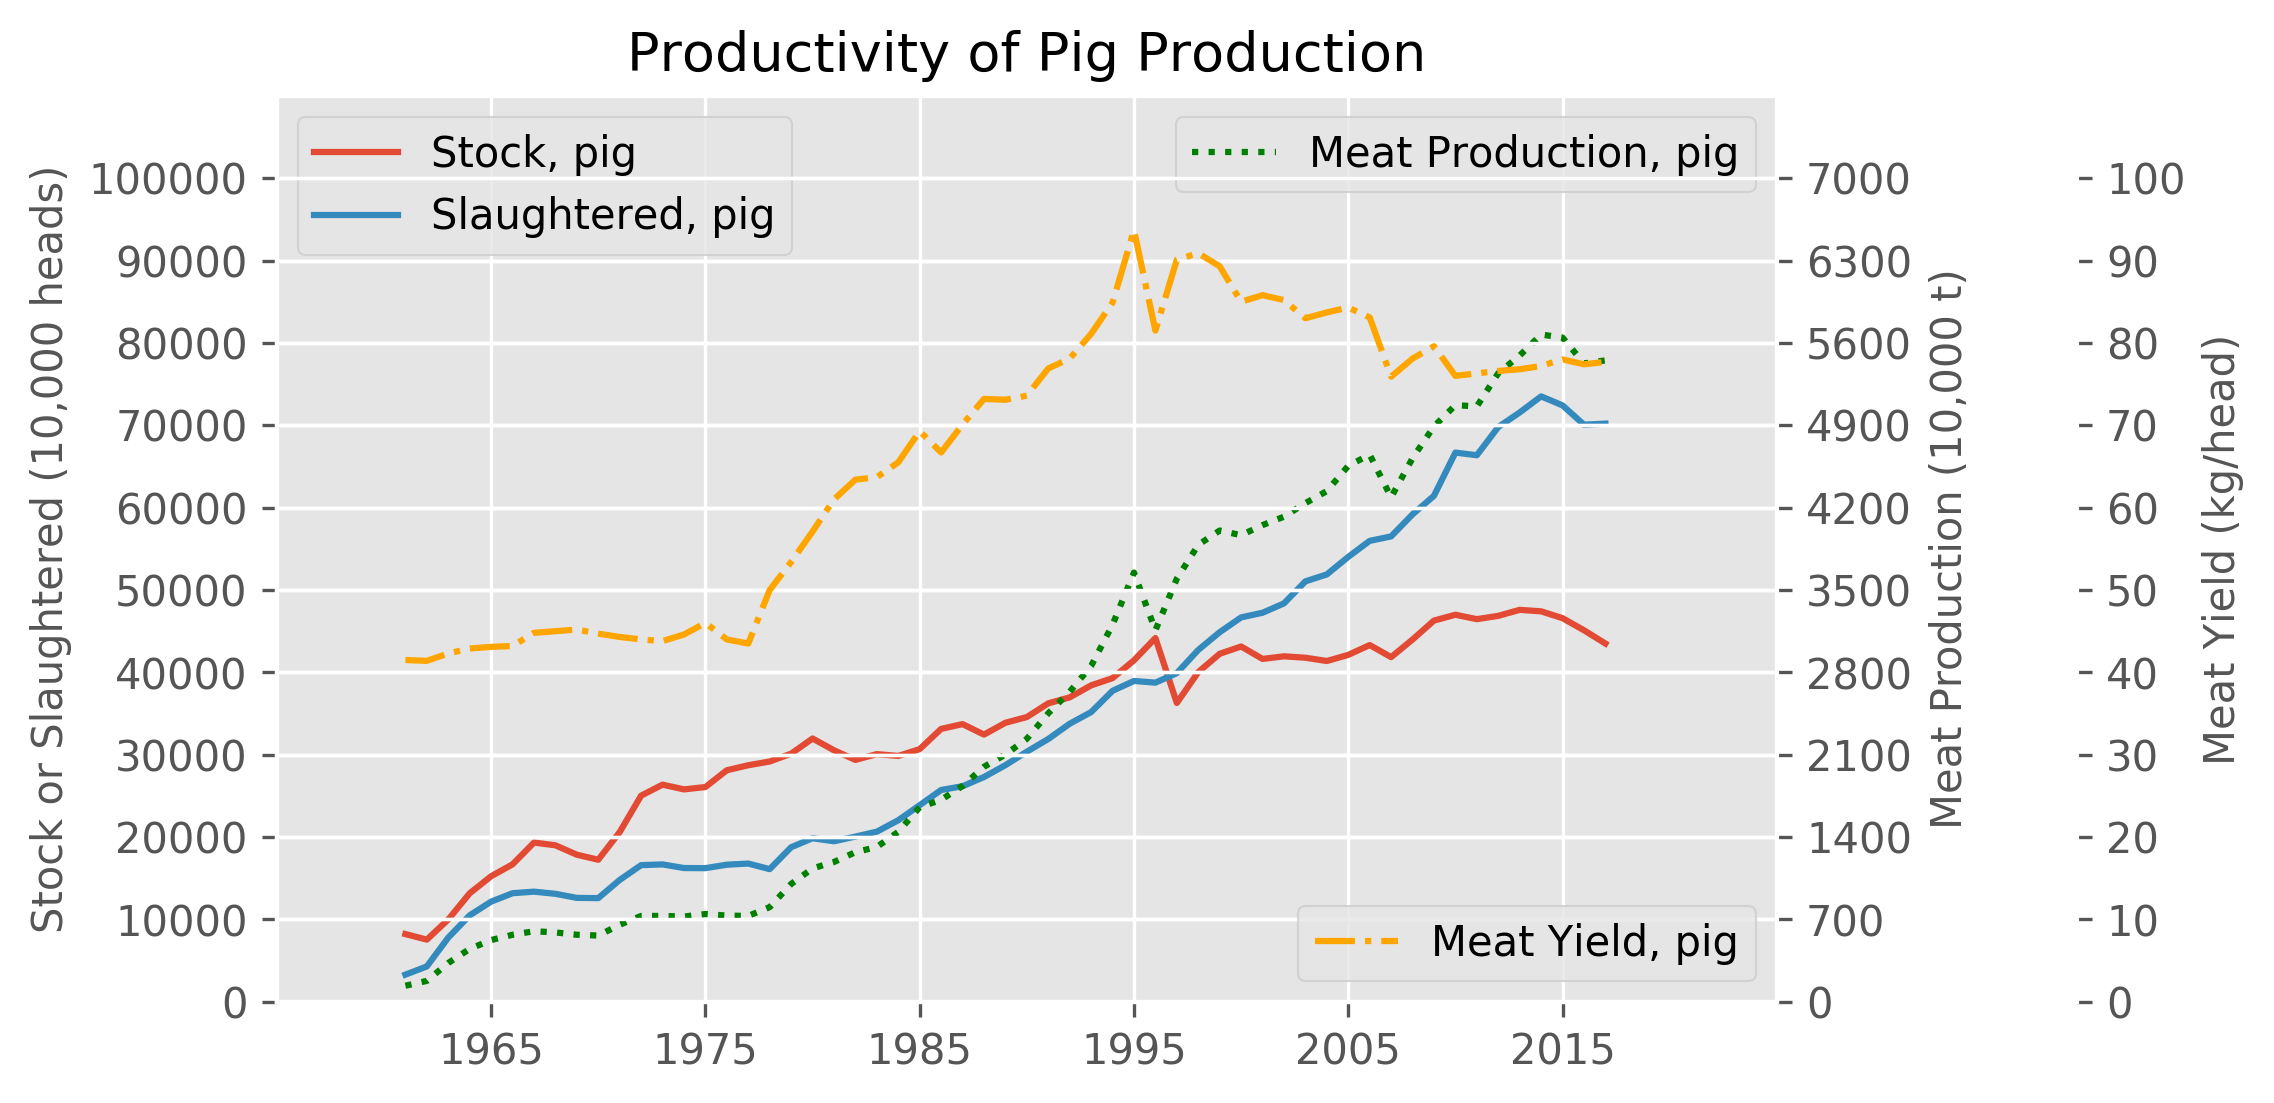

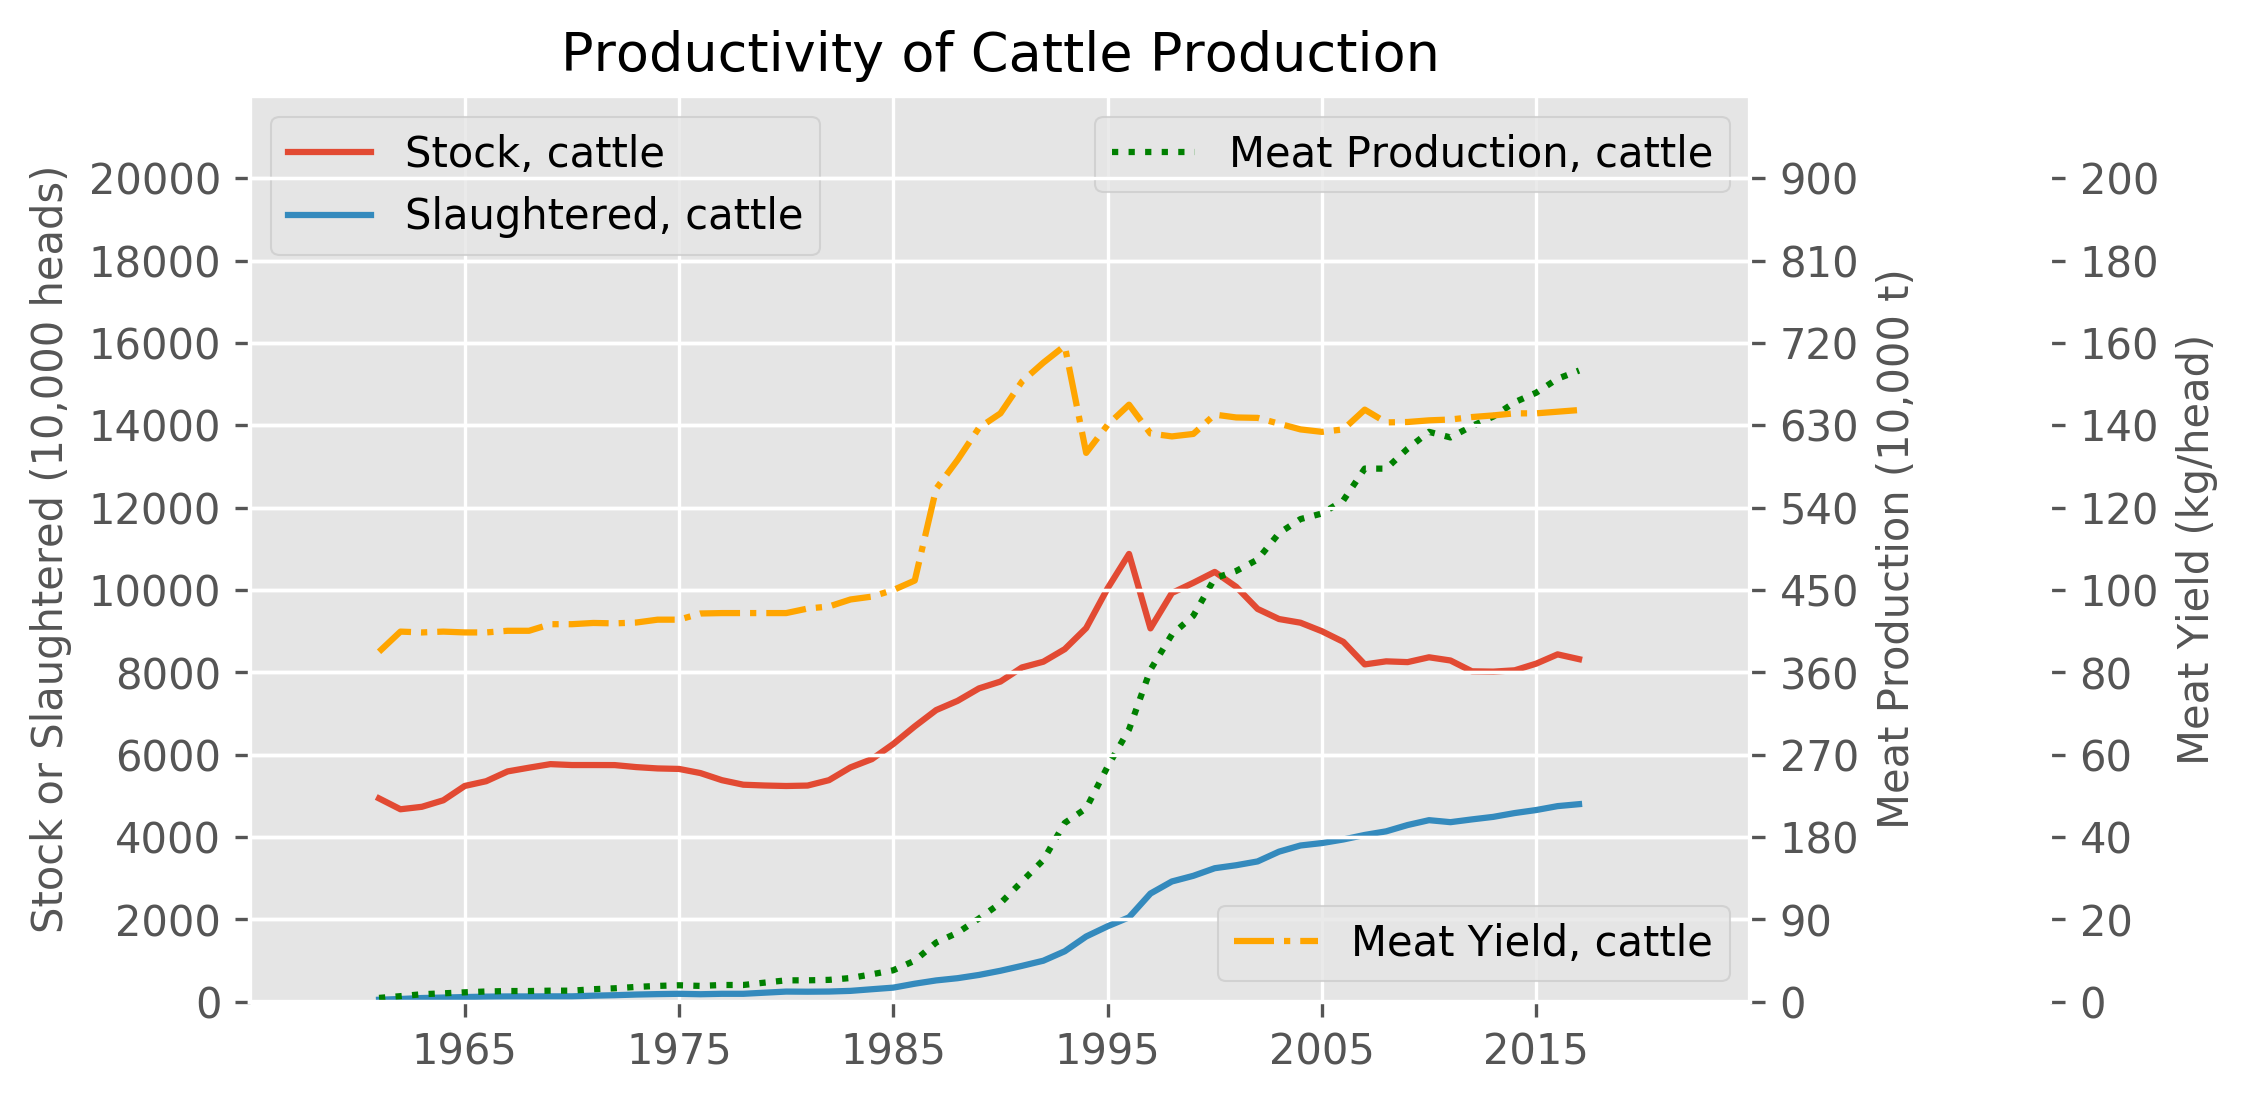

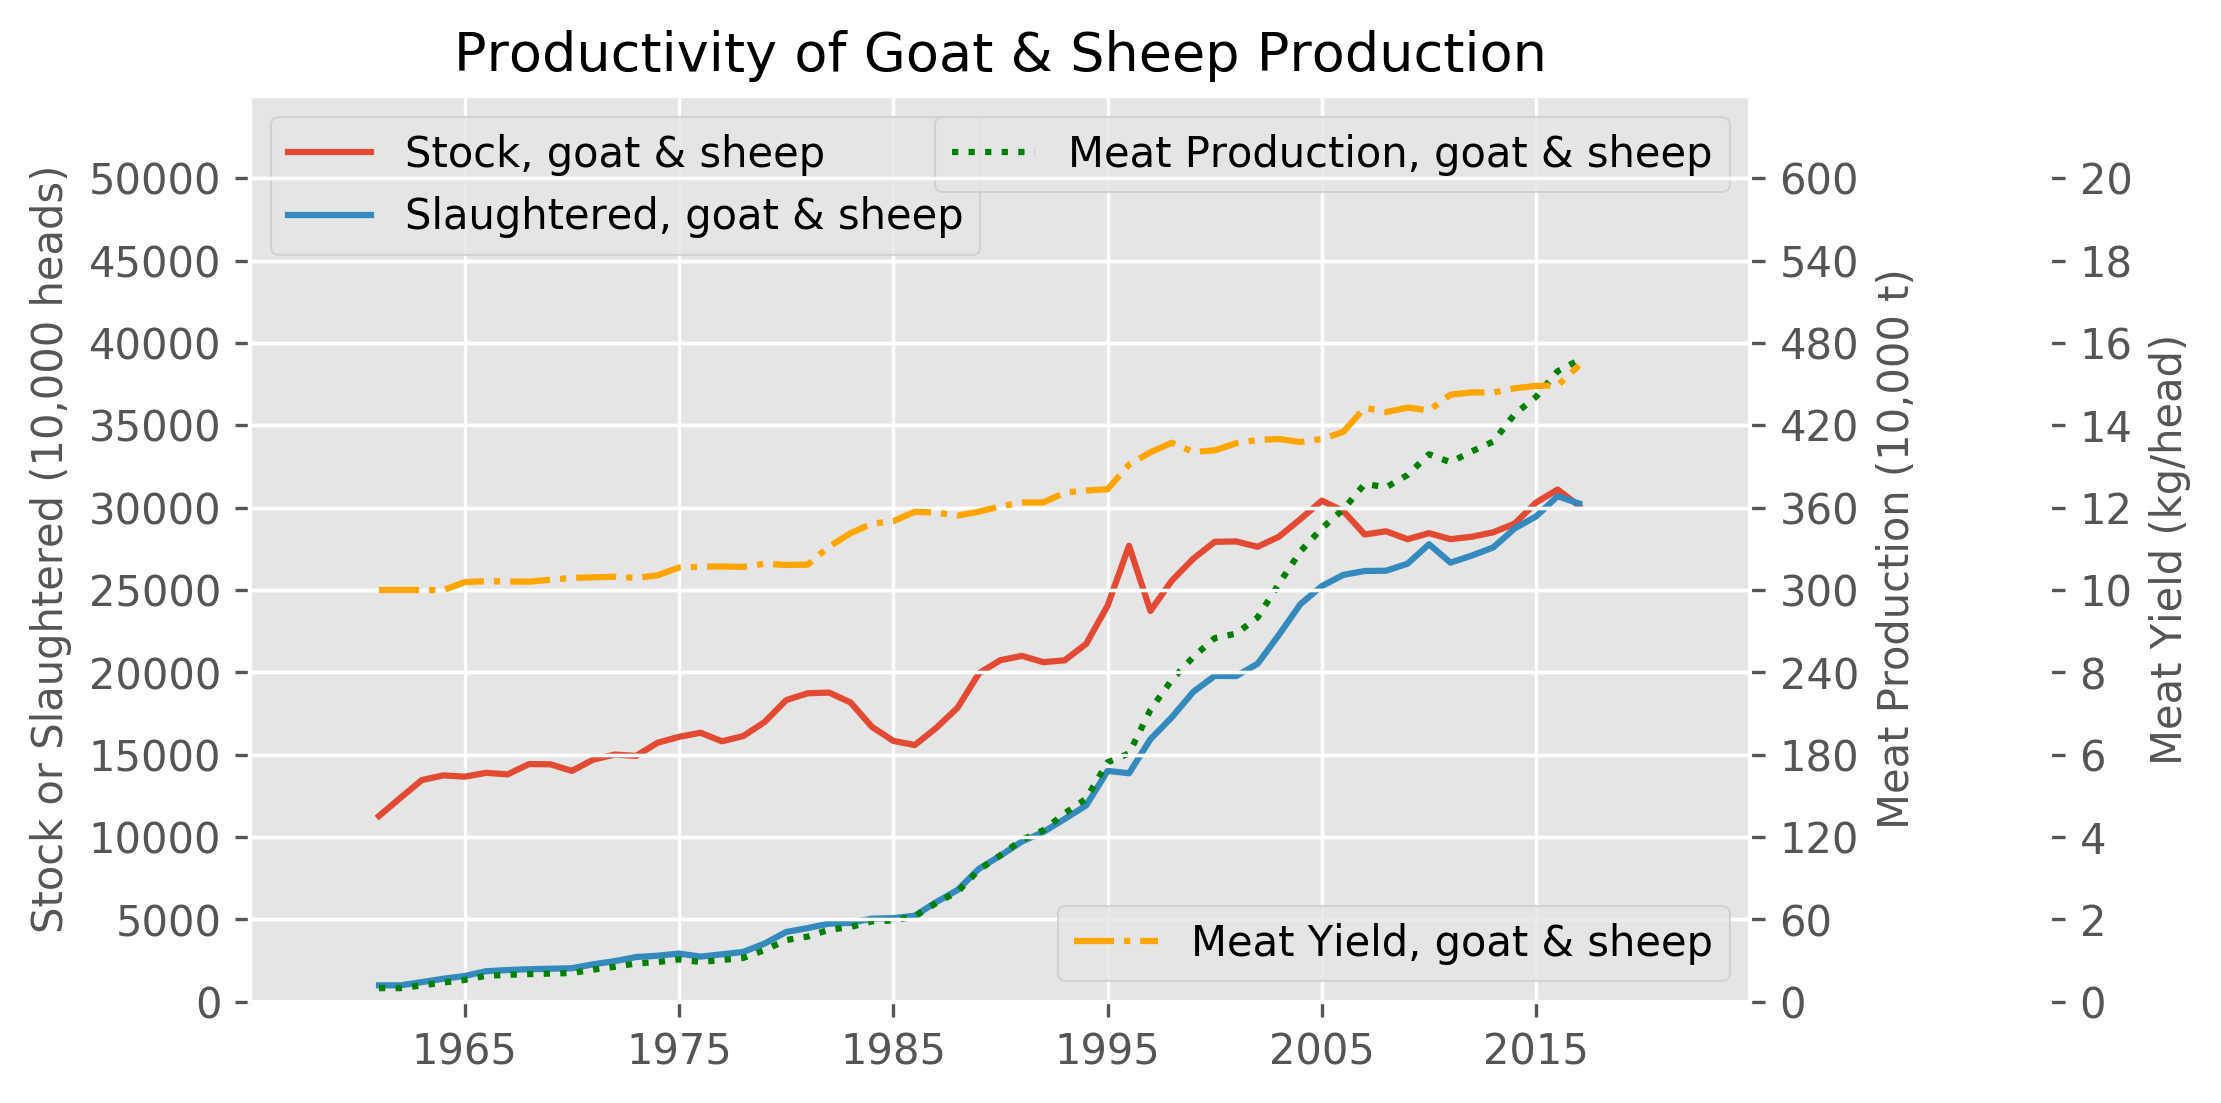

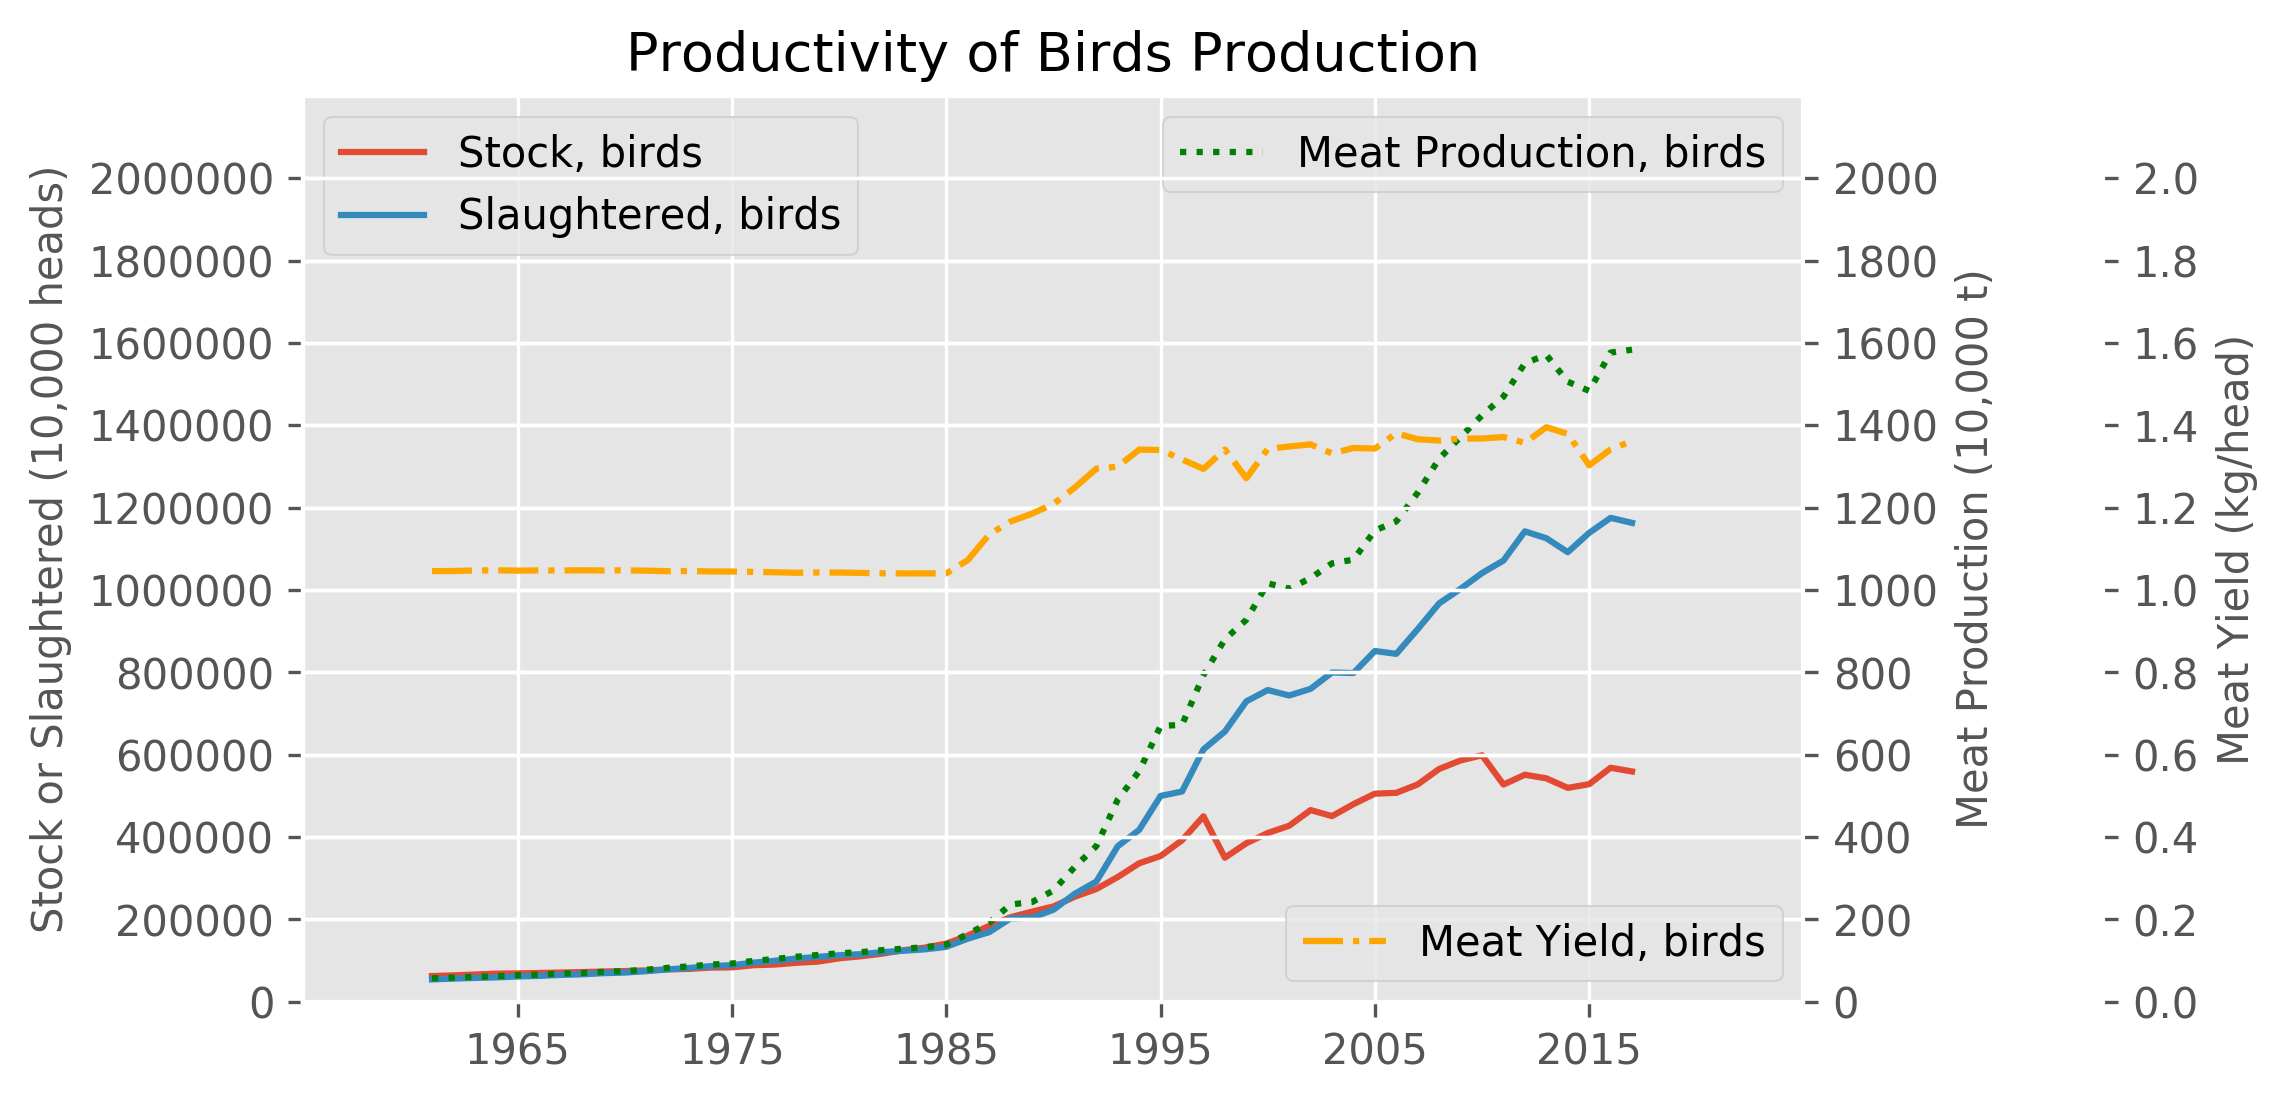

In [27]:
area = 'China, mainland'

plotProductivity(
    df_=df, 
    area_=area, 
    fig_size = (8,4)
)

### Aquatic production by Captured and Aquacultured in Manland China
### 中国大陆水产的捕捞产量和养殖产量

In [28]:
def plotAquatic(
    df_,
    area_,
    fig_size,
):    
    items = ['Marine, capture', 'Marine, aquac.', 'Freshwater, capture', 'Freshwater, aquac.']

    df_=df_.copy()
    df_res = df_[df_['Area']=='China, mainland'][['Year']+items]
    df_res['Sum'] = df_res[items].apply(lambda x: x.sum(), axis=1)
    df_res = df_res.dropna()

    display(df_res.head())

    fig = plt.figure(figsize = fig_size, dpi = 300)
    fig.tight_layout()                          
    plt.subplots_adjust(wspace =0.5, hspace =0.12)

    years = range(1980, DATA_YEAR)                                     # years  
    step = 5                                                        # for X ticks
    X_ticks = list(range(years[0], years[-1]+years[-1]%step, step))   # X ticks
    Y_lab = 'Aquatic Production (10,000 t)'                                    # Y label
    title = "Captured and Aquacultured Aquatic Production in {}".format(area_)                   # title

    colors=['lightskyblue','b', 'chartreuse','g']

    # === Line Plot
    ax0 = fig.add_subplot(3,1,1)
    plt.title(title, fontsize=TIT_size)

    df_res[['Year']+items].plot.line(x='Year',color=colors, ax=plt.gca())
    Y_max = df_res[items].values.max()
    
    ax=plt.gca()
    ax.legend(frameon=False, loc='center left', fontsize=LEG_size,
              bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
    setX_quant(ax, X_ticks, step)
    setY_quant(ax, Y_max, Y_lab)


    # === Stacked stream (absolute values) ===
    ax1 = fig.add_subplot(3,1,2)
    
    df_res[['Year']+items].plot.area(x='Year', color=colors, stacked=True, ax=plt.gca())
    Y_max = df_res['Sum'].values.max()
    
    ax = plt.gca()
    ax.legend(frameon=False, loc='center left', fontsize=LEG_size,
           bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
    setX_quant(ax, X_ticks, step)
    setY_quant(ax, Y_max, Y_lab)


    # === Stacked stream (percentages) ===
    ax2 = fig.add_subplot(3,1,3)
    
    for i in items:
        df_res[i]=df_res[i]/df_res['Sum']*100
    display(df_res.head())
    df_res[['Year']+items].plot.area(x='Year', color=colors, stacked=True, ax=plt.gca())
    
    ax = plt.gca()
    ax.legend(frameon=False, loc='center left', fontsize=LEG_size,
           bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
    setX_quant(ax, X_ticks, step)
    setY_per(ax)

    # === Save img
    path = './results/CN_AnimalProduction/img/Fig_4_'+title+'.png'
    bbox = matplotlib.transforms.Bbox([[-1, -0], [10, 15]])
    fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
    print('Img saved as: ' + path)

Year  Marine, capture  Marine, aquac.  Freshwater, capture  \
17  1978           314.50           45.30                29.50   
19  1980           281.30           44.41                33.97   
24  1985           348.51           71.23                47.64   
25  1986           389.60           85.80                53.80   
26  1987           438.20          110.00                60.00   

    Freshwater, aquac.     Sum  
17               76.20  465.50  
19               90.02  449.70  
24              237.77  705.15  
25              294.40  823.60  
26              347.20  955.40

Year  Marine, capture  Marine, aquac.  Freshwater, capture  \
17  1978        67.561762        9.731472             6.337272   
19  1980        62.552813        9.875473             7.553925   
24  1985        49.423527       10.101397             6.756009   
25  1986        47.304517       10.417678             6.532297   
26  1987        45.865606       11.513502             6.280092   

    Freshwater, aquac.     Sum  
17           16.369495  465.50  
19           20.017790  449.70  
24           33.719067  705.15  
25           35.745508  823.60  
26           36.340800  955.40

Img saved as: ./results/CN_AnimalProduction/img/Fig_4_Captured and Aquacultured Aquatic Production in China, mainland.png


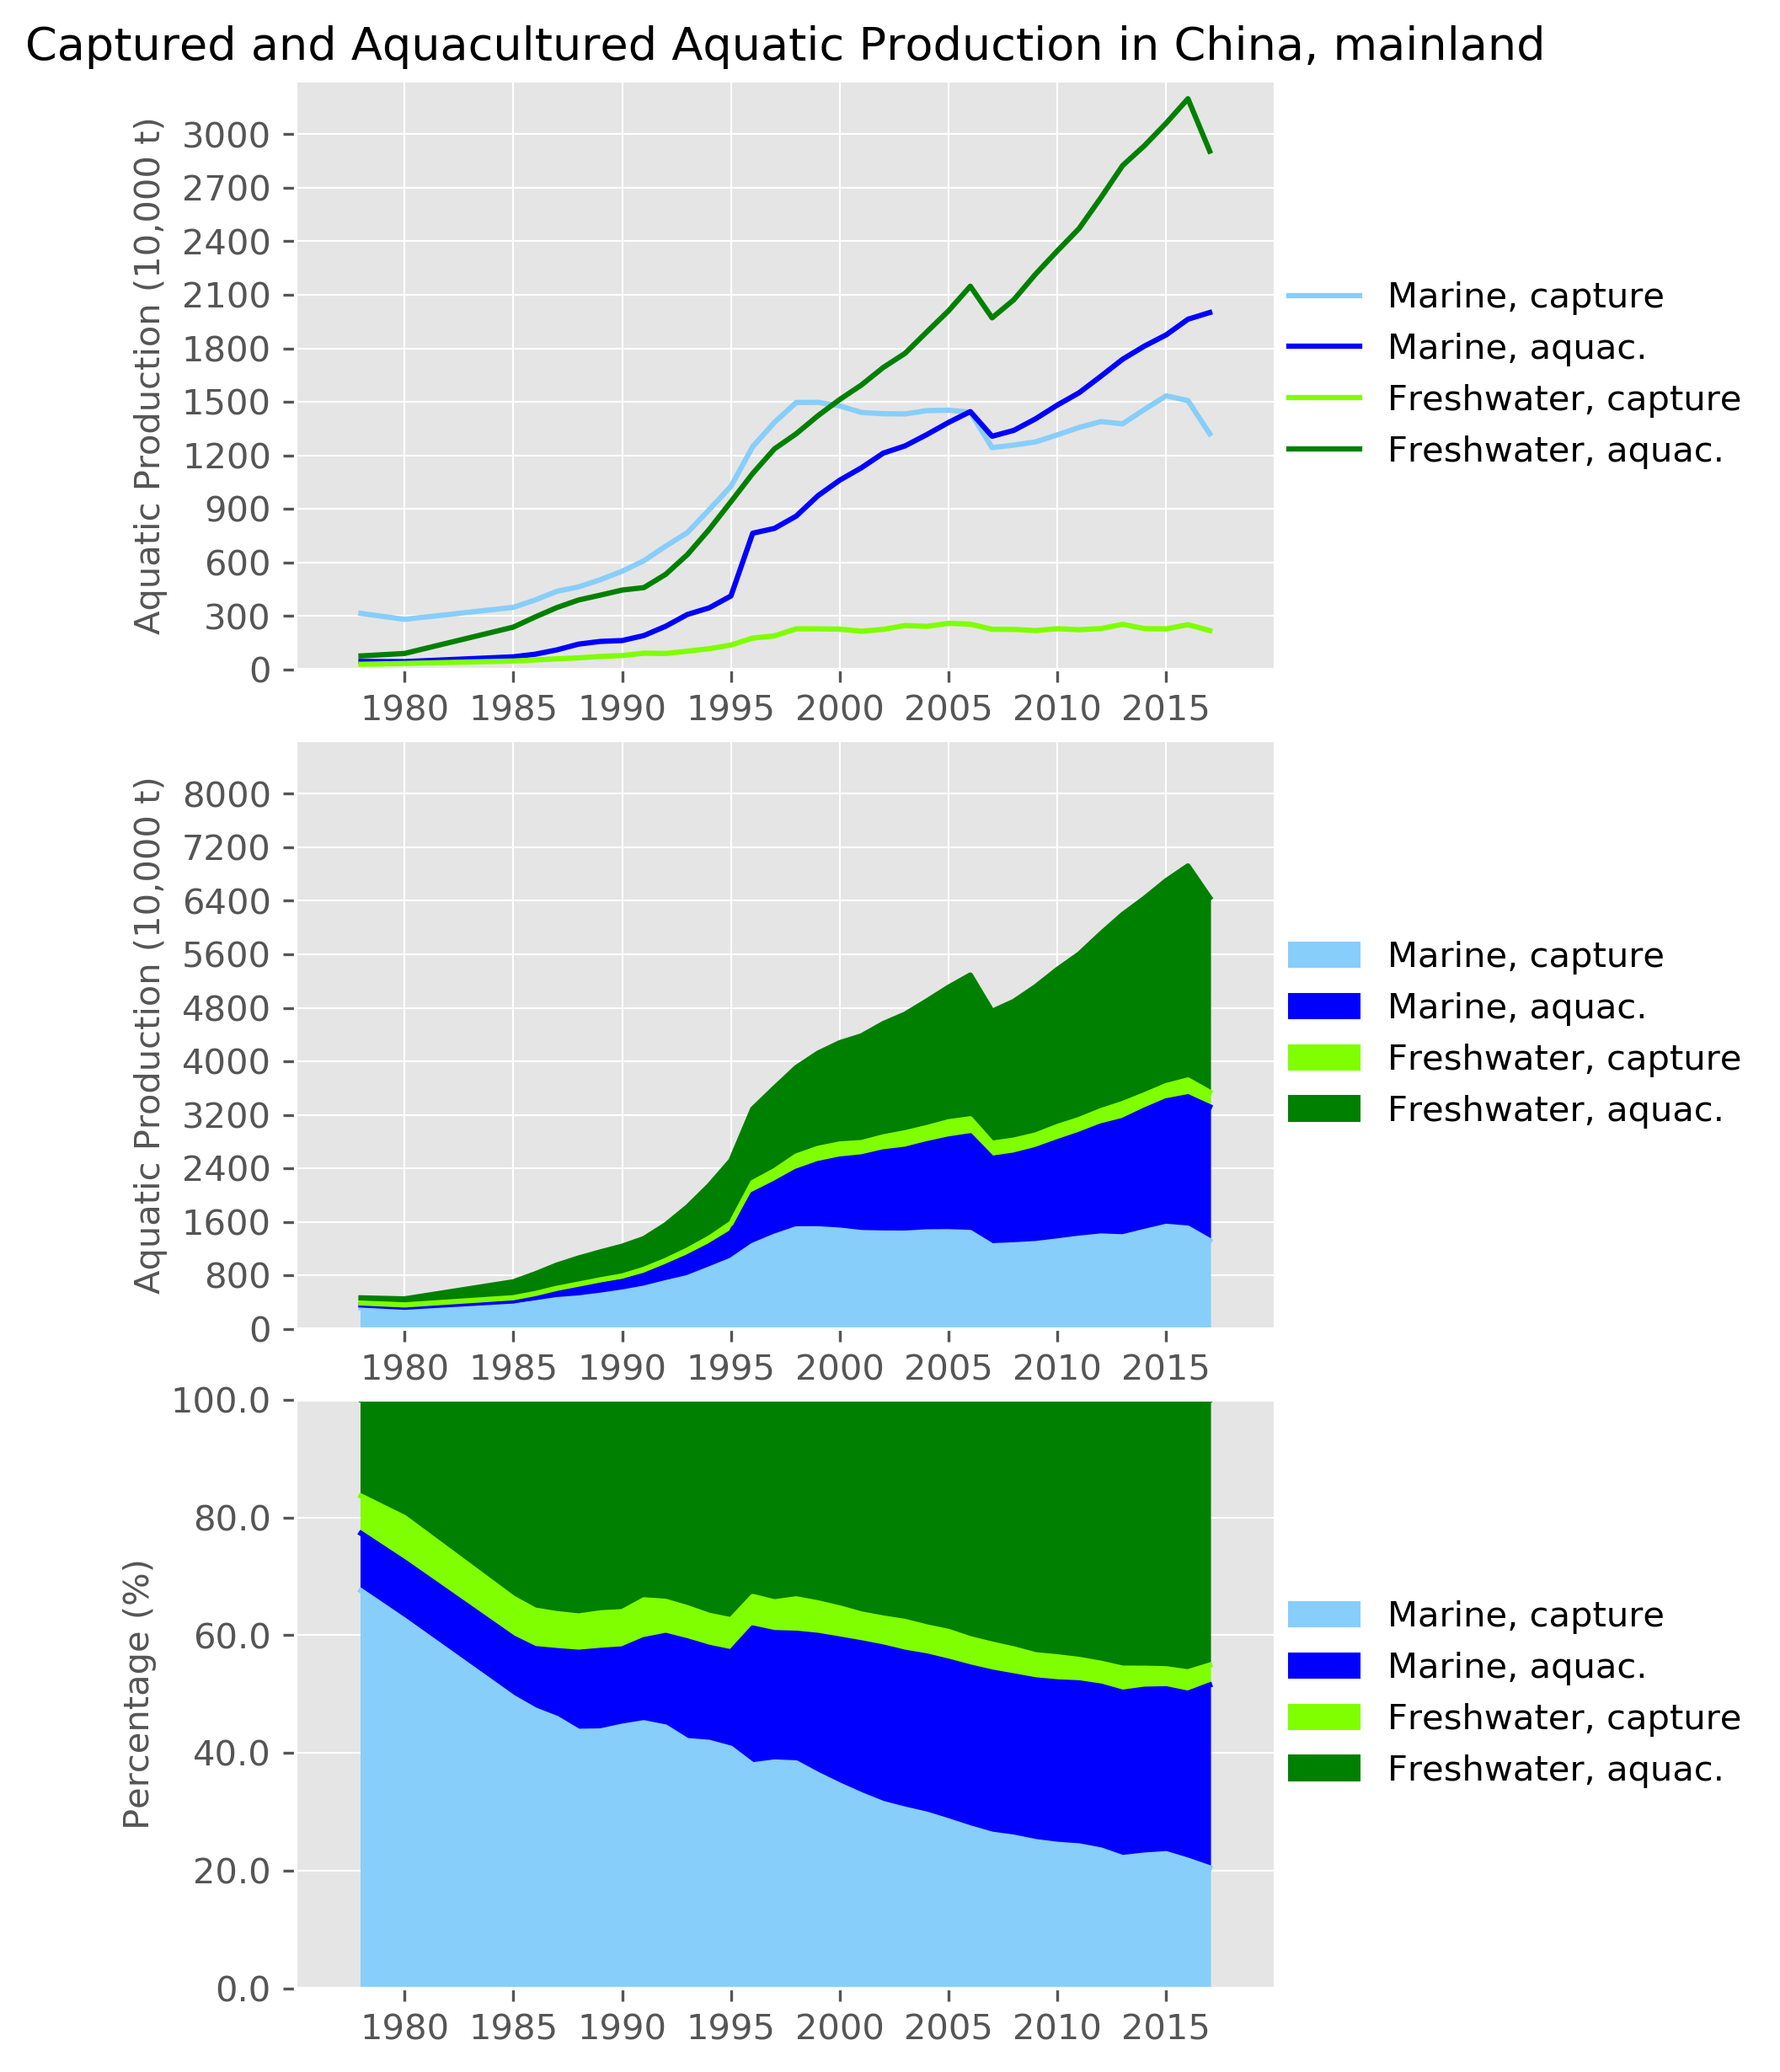

In [22]:
area = 'China, mainland'

plotAquatic(
    df_=df,
    area_=area,
    fig_size=(5,10)
)